<a href="https://colab.research.google.com/github/jojosam90/anomaly_detection/blob/main/ops_padim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#pip install anomalib
#!pip install tarfile

In [3]:
#!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz

In [4]:
#import tarfile

#file = tarfile.open('/content/mvtec_anomaly_detection.tar.xz')
#file.extractall('/content/mvtec_anomaly')
#file.close()

In [5]:
!git clone https://github.com/jojosam90/anomalib.git
%cd anomalib
!pip install -e . -q

Cloning into 'anomalib'...
remote: Enumerating objects: 12181, done.
remote: Counting objects: 100% (852/852), done.
remote: Compressing objects: 100% (391/391), done.
remote: Total 12181 (delta 438), reused 727 (delta 359), pack-reused 11329
Receiving objects: 100% (12181/12181), 14.86 MiB | 29.95 MiB/s, done.
Resolving deltas: 100% (7130/7130), done.
/content/anomalib
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.2 MB 5.1 MB/s 
     |████████████████████████████████| 409 kB 71.0 MB/s 
     |████████████████████████████████| 102 kB 74.5 MB/s 
     |████████████████████████████████| 60.5 MB 68 kB/s 
     |████████████████████████████████| 5.1 MB 53.4 MB/s 
     |████████████████████████████████| 584 kB 69.2 MB/s 
     |████████████████████████████████| 1.7 MB 56.4 MB/s 
     |████████████████████████████████| 78 kB 9.6 MB/s 
     |████████████████████████████████| 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os, pprint, yaml, warnings, math, glob, cv2, random, logging

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')
logger = logging.getLogger("anomalib")

import anomalib
from pytorch_lightning import Trainer, seed_everything
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import configure_logger, get_experiment_logger

In [7]:
import torch
import cv2 as cv

In [8]:
CONFIG_PATHS = '/content/anomalib/anomalib/models'
MODEL_CONFIG_PAIRS = {
    'patchcore': f'{CONFIG_PATHS}/patchcore/config.yaml',
    'padim':     f'{CONFIG_PATHS}/padim/config.yaml',
    'cflow':     f'{CONFIG_PATHS}/cflow/config.yaml',
    'dfkde':     f'{CONFIG_PATHS}/dfkde/config.yaml',
    'dfm':       f'{CONFIG_PATHS}/dfm/config.yaml',
    'ganomaly':  f'{CONFIG_PATHS}/ganomaly/config.yaml',
    'stfpm':     f'{CONFIG_PATHS}/stfpm/config.yaml',
}

In [9]:
MODEL = 'patchcore' # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
#MODEL = 'padim' # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
print(open(os.path.join(MODEL_CONFIG_PAIRS[MODEL]), 'r').read())

dataset:
  name: mvtec #options: [mvtec, btech, folder]
  format: mvtec
  path: ./datasets/MVTec
  task: segmentation
  category: bottle
  image_size: 224
  train_batch_size: 32
  test_batch_size: 1
  num_workers: 0
  transform_config:
    train: null
    val: null
  create_validation_set: false
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: patchcore
  backbone: wide_resnet50_2
  layers:
    - layer2
    - layer3
  coreset_sampling_ratio: 0.1
  num_neighbors: 9
  weight_file: weights/model.ckpt
  normalization_method: min_max # options: [null, min_max, cdf]

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC
  threshold:
    image_default: 0
    pixel_default: 0
    adaptive: true

project:
  seed: 0
  path: ./results
  log_images_to: [local]
  logger: false # options: [tensorboard, wandb, csv] or combinations.

# PL Trainer Args. Don't add ext

In [10]:
new_update = {
    "path": '/content/drive/MyDrive/dataset/',
    'category': 'ops', 
    'image_size': 256,
    'train_batch_size':48,
    'seed': 101
}

In [11]:
def update_yaml(old_yaml, new_yaml, new_update):
    # load yaml
    with open(old_yaml) as f:
        old = yaml.safe_load(f)
                  
    temp = []
    def set_state(old, key, value):
        if isinstance(old, dict):
            for k, v in old.items():
                if k == 'project':
                    temp.append(k)
                if k == key:
                    if temp and k == 'path':
                        # right now, we don't wanna change `project.path`
                        continue
                    old[k] = value
                elif isinstance(v, dict):
                    set_state(v, key, value)
    
    # iterate over the new update key-value pari
    for key, value in new_update.items():
        set_state(old, key, value)
    
    # save the updated / modified yaml file
    with open(new_yaml, 'w') as f:
        yaml.safe_dump(old, f, default_flow_style=False)

In [12]:
# let's set a new path location of new config file 
new_yaml = CONFIG_PATHS + '/' + list(MODEL_CONFIG_PAIRS.keys())[0] + '_new.yaml'

# run the update yaml method to update desired key's values
update_yaml(MODEL_CONFIG_PAIRS[MODEL], new_yaml, new_update)

In [13]:
with open(new_yaml) as f:new = yaml.safe_load(f)
pprint.pprint(new) # check if it's updated

{'dataset': {'category': 'ops',
             'create_validation_set': False,
             'format': 'mvtec',
             'image_size': 256,
             'name': 'mvtec',
             'num_workers': 0,
             'path': '/content/drive/MyDrive/dataset/',
             'task': 'segmentation',
             'test_batch_size': 1,
             'tiling': {'apply': False,
                        'random_tile_count': 16,
                        'remove_border_count': 0,
                        'stride': None,
                        'tile_size': None,
                        'use_random_tiling': False},
             'train_batch_size': 48,
             'transform_config': {'train': None, 'val': None}},
 'metrics': {'image': ['F1Score', 'AUROC'],
             'pixel': ['F1Score', 'AUROC'],
             'threshold': {'adaptive': True,
                           'image_default': 0,
                           'pixel_default': 0}},
 'model': {'backbone': 'wide_resnet50_2',
           'coreset_sam

In [14]:
if new['project']['seed'] != 0:
    print(new['project']['seed'])
    seed_everything(new['project']['seed'])

Global seed set to 101


101


In [15]:
# It will return the configurable parameters in DictConfig object.
config = get_configurable_parameters(
    model_name=new['model']['name'],
    config_path=new_yaml
)

In [16]:
model      = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks  = get_callbacks(config)
datamodule = get_datamodule(config)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [17]:
# start training
trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AdaptiveThreshold        | 0     
1 | pixel_threshold       | AdaptiveThreshold        | 0     
2 | training_distribution | AnomalyScoreDistribution | 0     
3 | min_max               | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [18]:
#path = '/content/mvtec_anomaly/ops/train/good/1.png'
#image = cv2.imread(path)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [19]:
#image.dtype

In [20]:
!python -m pip uninstall matplotlib -yticks
!pip install matplotlib==3.1.3 


Usage:   
  /usr/bin/python3 -m pip uninstall [options] <package> ...
  /usr/bin/python3 -m pip uninstall [options] -r <requirements file> ...

no such option: -t
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9034090638160706
      image_F1Score         0.9411765336990356
       pixel_AUROC          0.9858042001724243
      pixel_F1Score         0.2295503169298172
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'image_AUROC': 0.9034090638160706,
  'image_F1Score': 0.9411765336990356,
  'pixel_AUROC': 0.9858042001724243,
  'pixel_F1Score': 0.2295503169298172}]

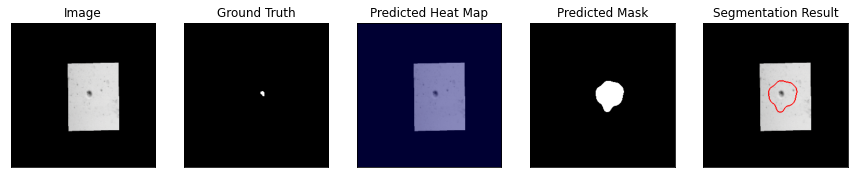

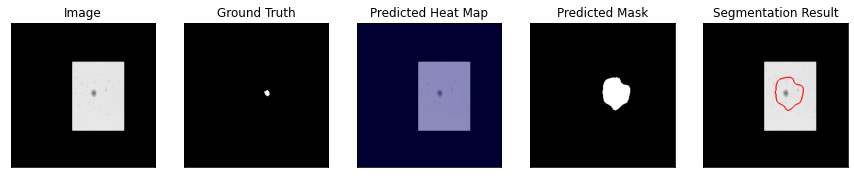

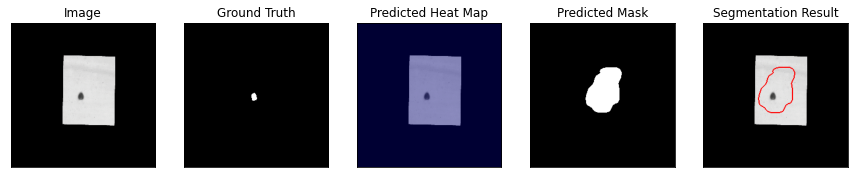

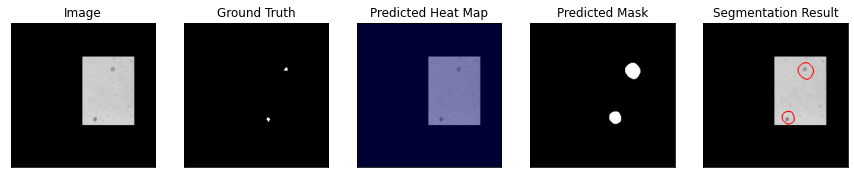

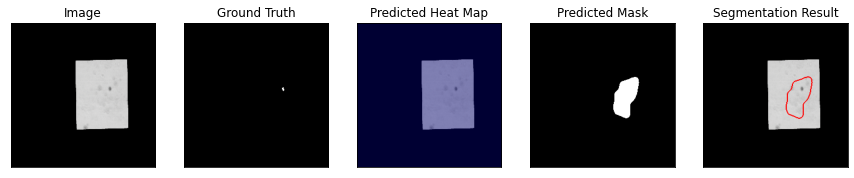

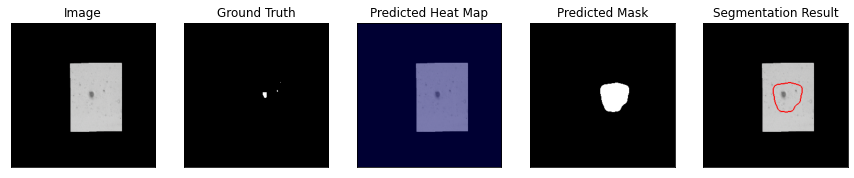

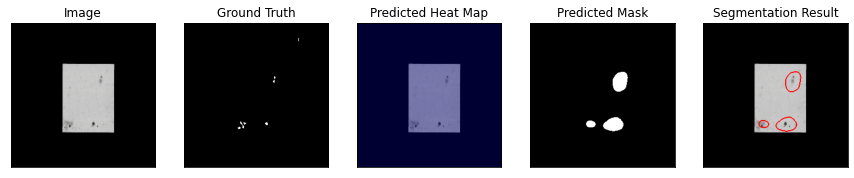

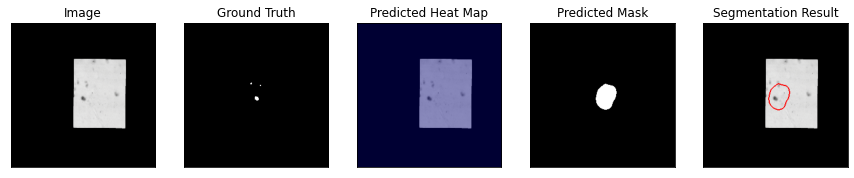

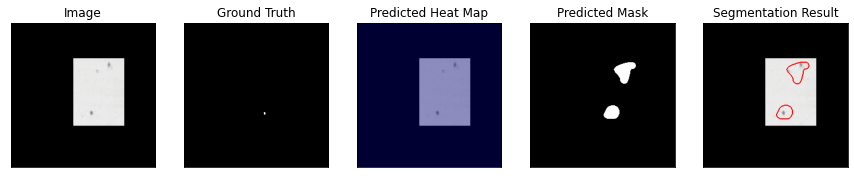

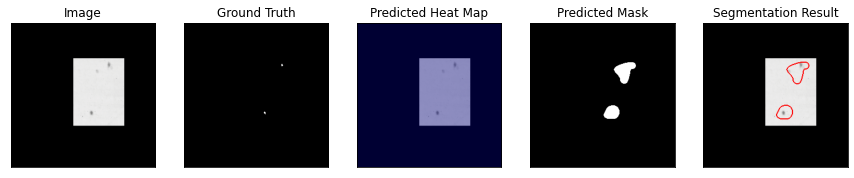

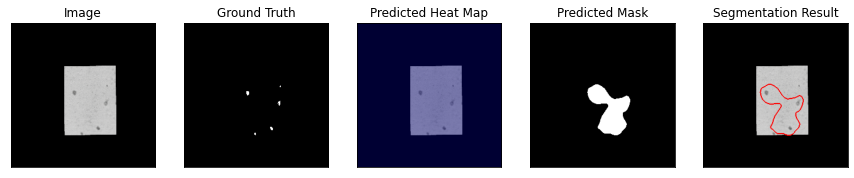

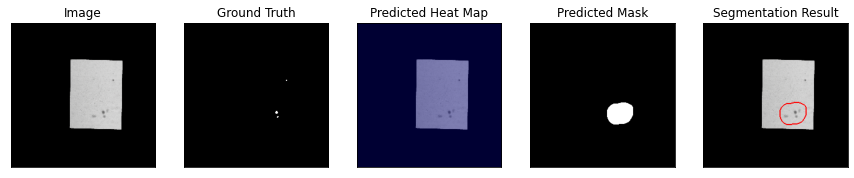

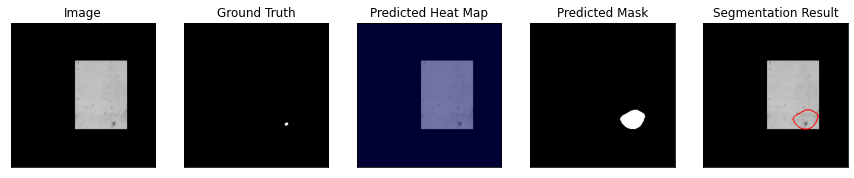

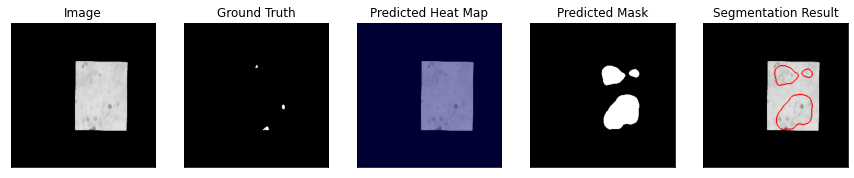

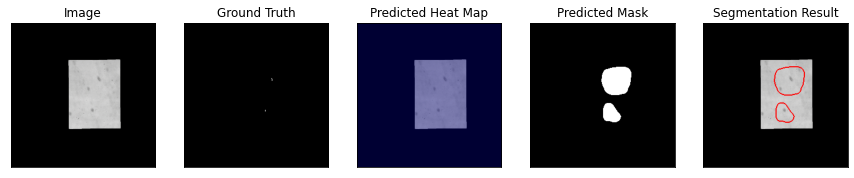

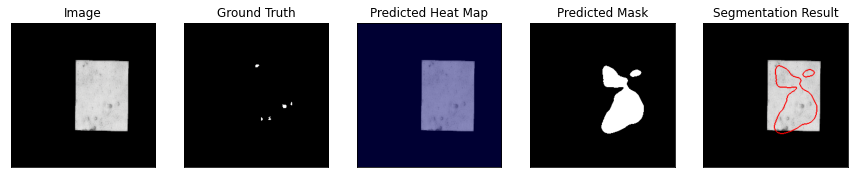

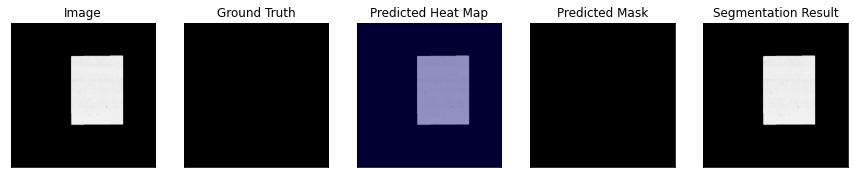

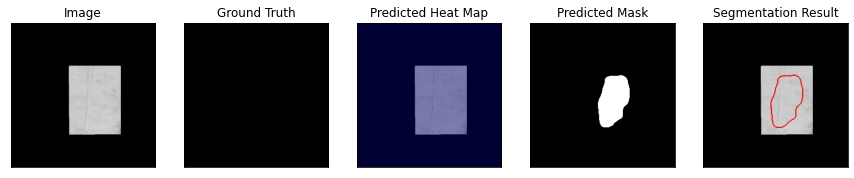

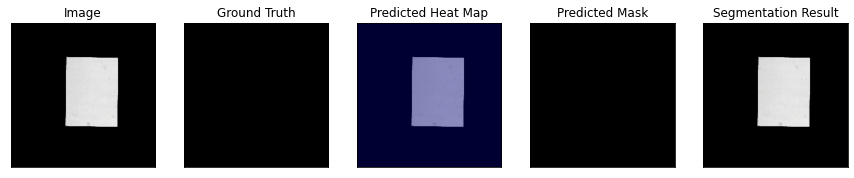

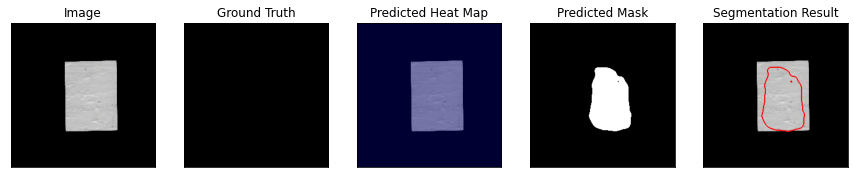

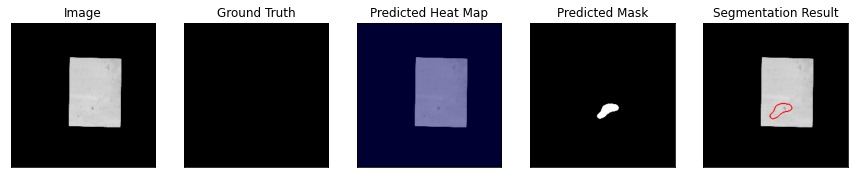

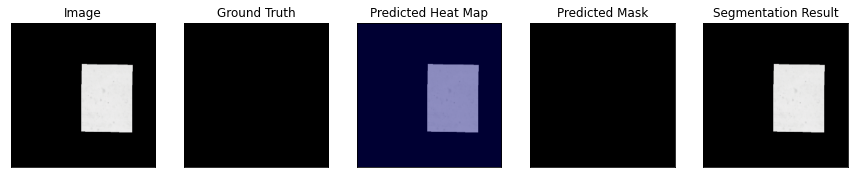

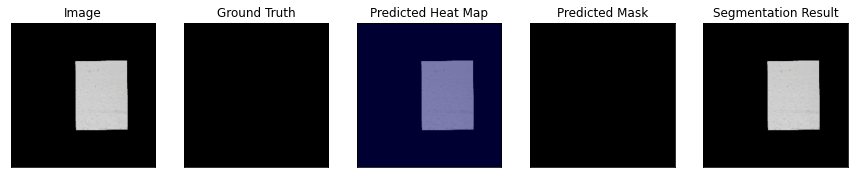

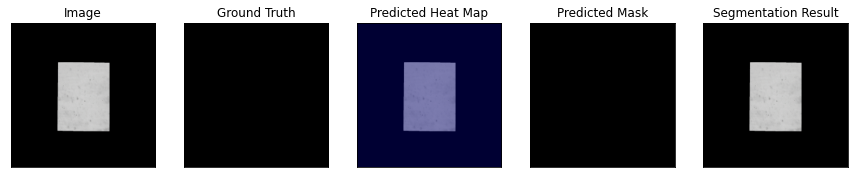

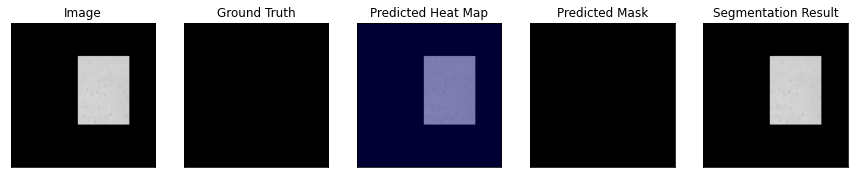

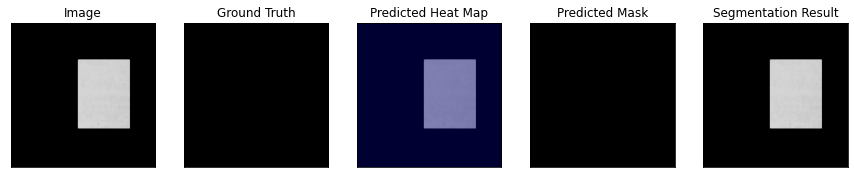

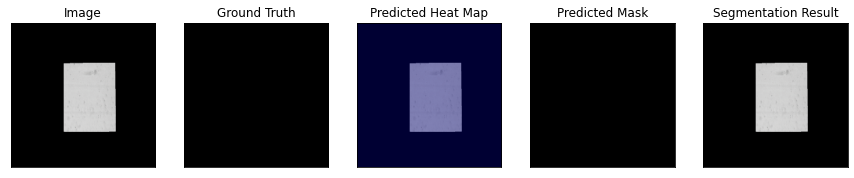

In [21]:
load_model_callback = LoadModelCallback(
    weights_path=trainer.checkpoint_callback.best_model_path
)
trainer.callbacks.insert(0, load_model_callback)
trainer.test(model=model, datamodule=datamodule)

In [22]:
RESULT_PATH = os.path.join(
    new['project']['path'],
    new['model']['name'],
    new['dataset']['format'], 
    new['dataset']['category']
)
RESULT_PATH

'./results/patchcore/mvtec/ops'

In [23]:
# a simple function to visualize the model's prediction (anomaly heatmap)
def vis(paths, n_images, is_random=True, figsize=(16, 16)):
    for i in range(n_images):
        image_name = paths[i]
        if is_random: image_name = random.choice(paths)
        img = cv2.imread(image_name)[:,:,::-1]
        
        category_type = image_name.split('/')[-4:-3:][0]
        defected_type = image_name.split('/')[-2:-1:][0]
        
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.title(
            f"Category : {category_type} and Defected Type : {defected_type}", 
            fontdict={'fontsize': 20, 'fontweight': 'medium'}
        )
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

In [24]:
for content in os.listdir(RESULT_PATH):
    if content == 'images':
        full_path = glob.glob(os.path.join(RESULT_PATH, content, '**',  '*.png'), recursive=True)
        print('Total Image ', len(full_path))
        print(full_path[0].split('/'))
        print(full_path[0].split('/')[-2:-1:])
        print(full_path[0].split('/')[-4:-3:])

Total Image  27
['.', 'results', 'patchcore', 'mvtec', 'ops', 'images', 'good', '119.png']
['good']
['ops']


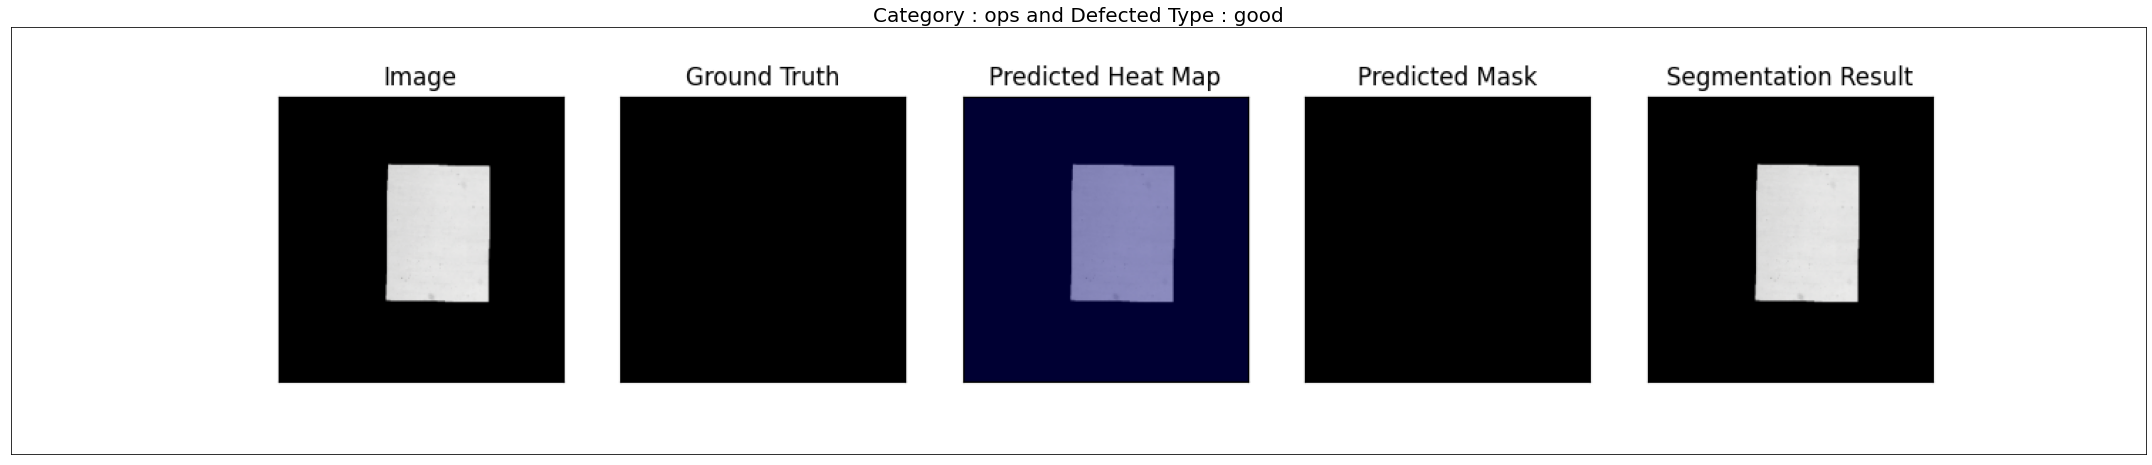

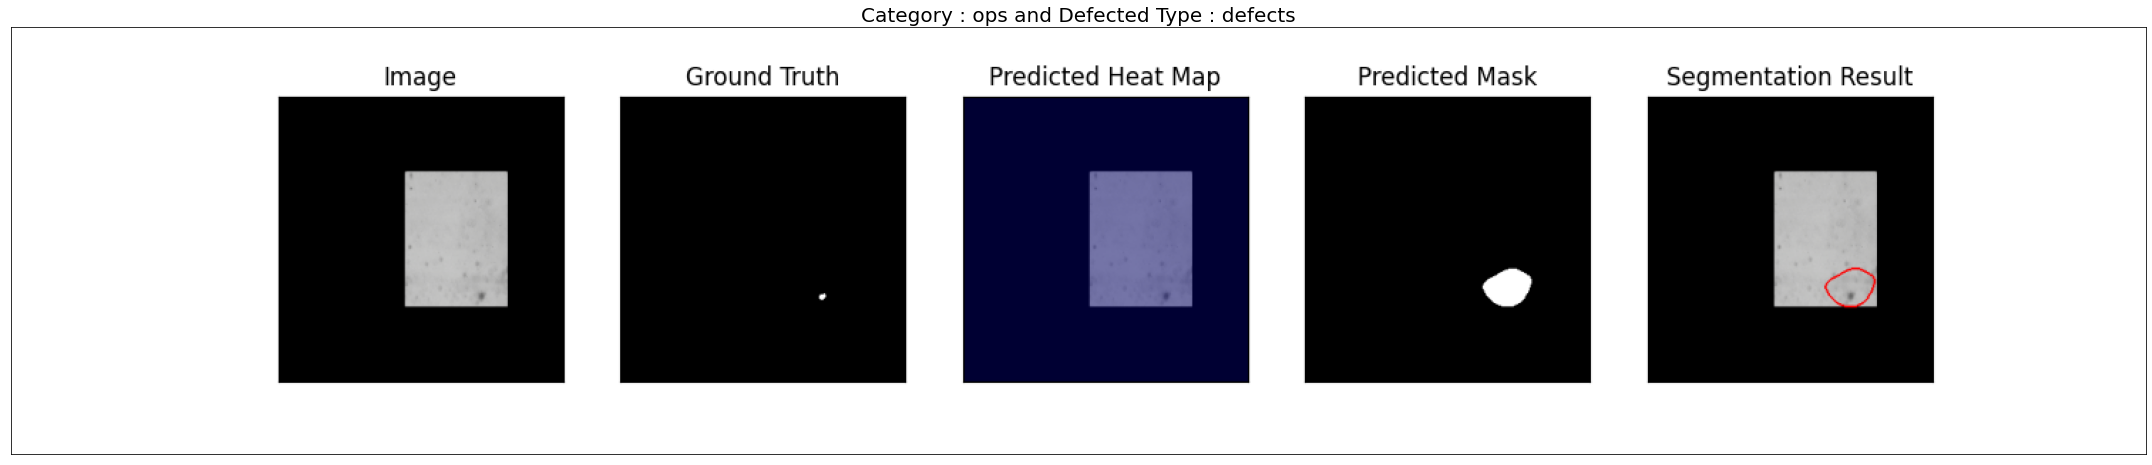

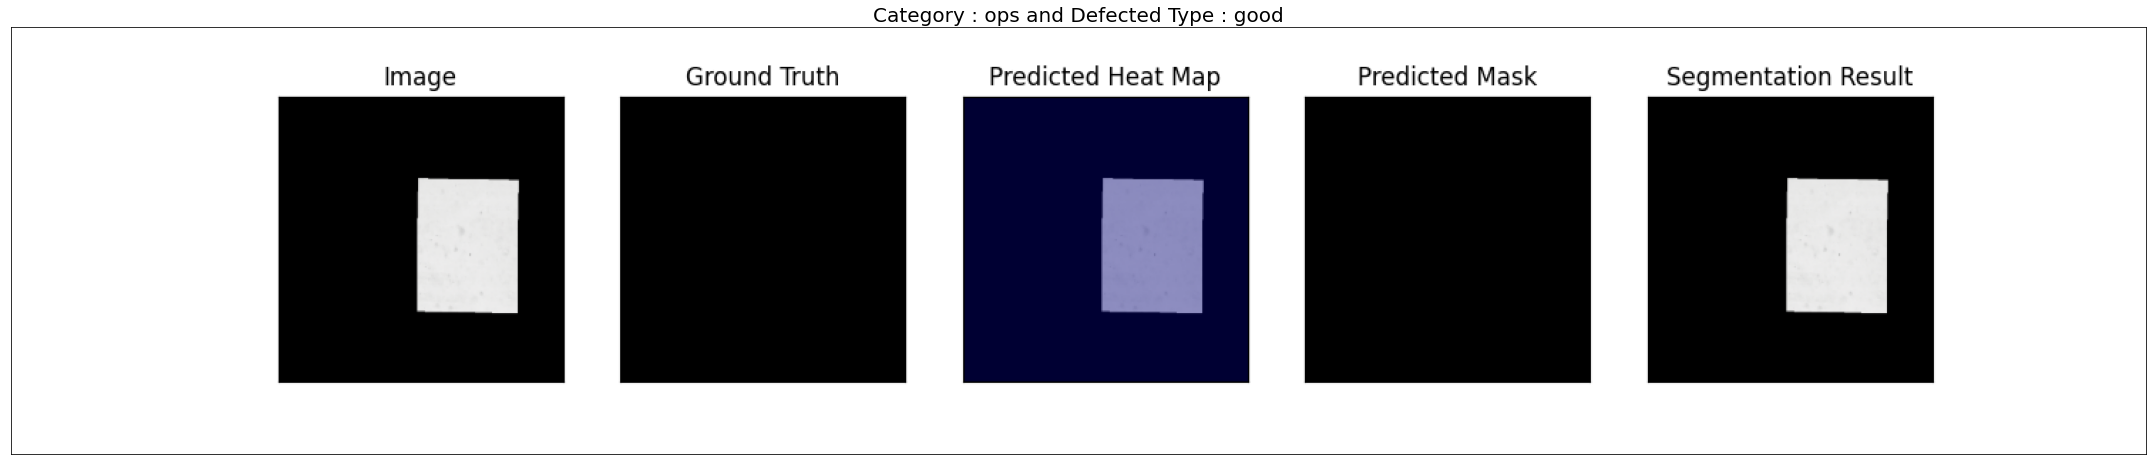

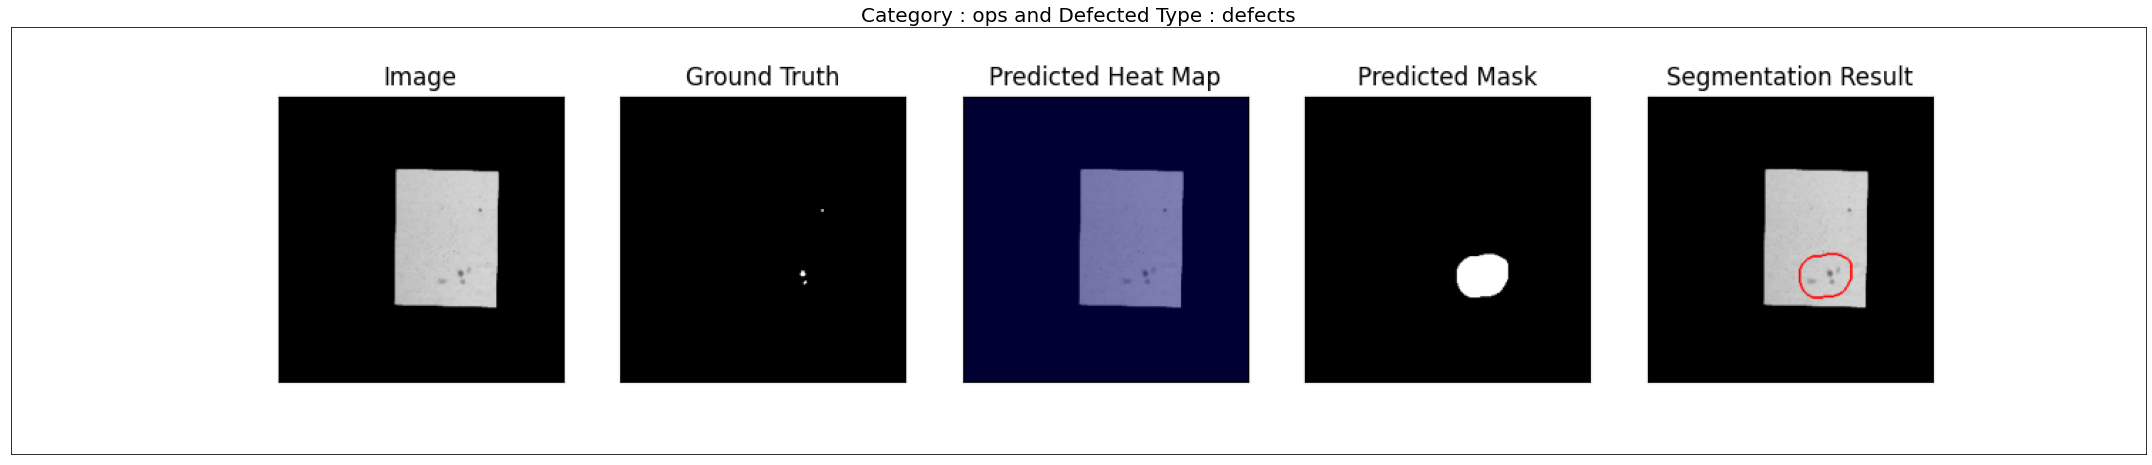

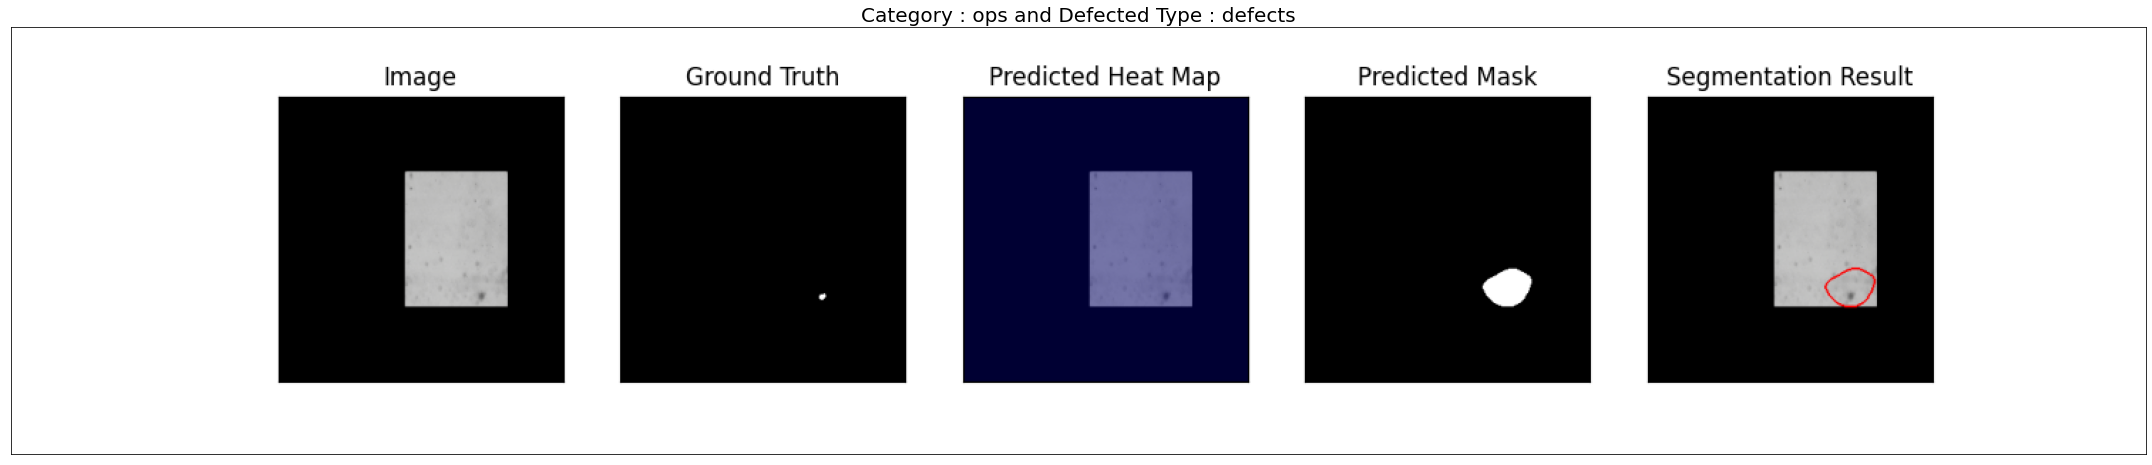

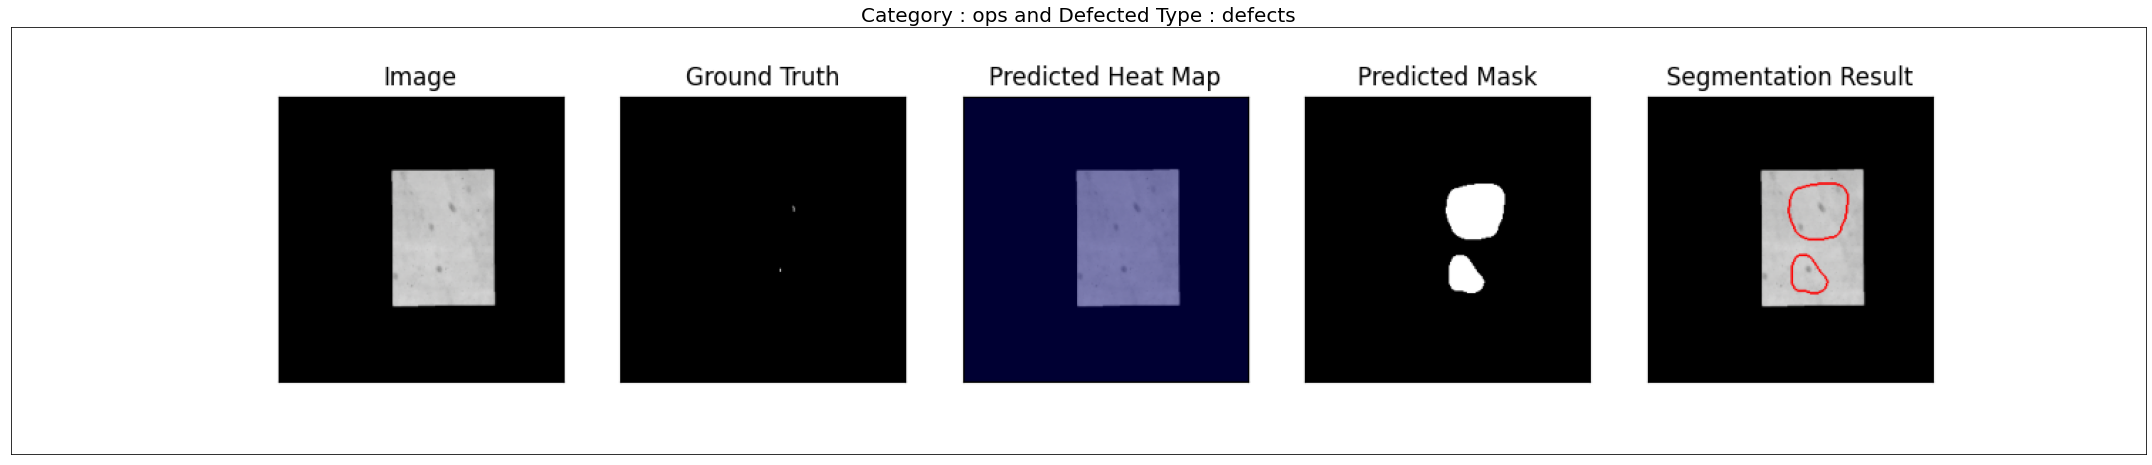

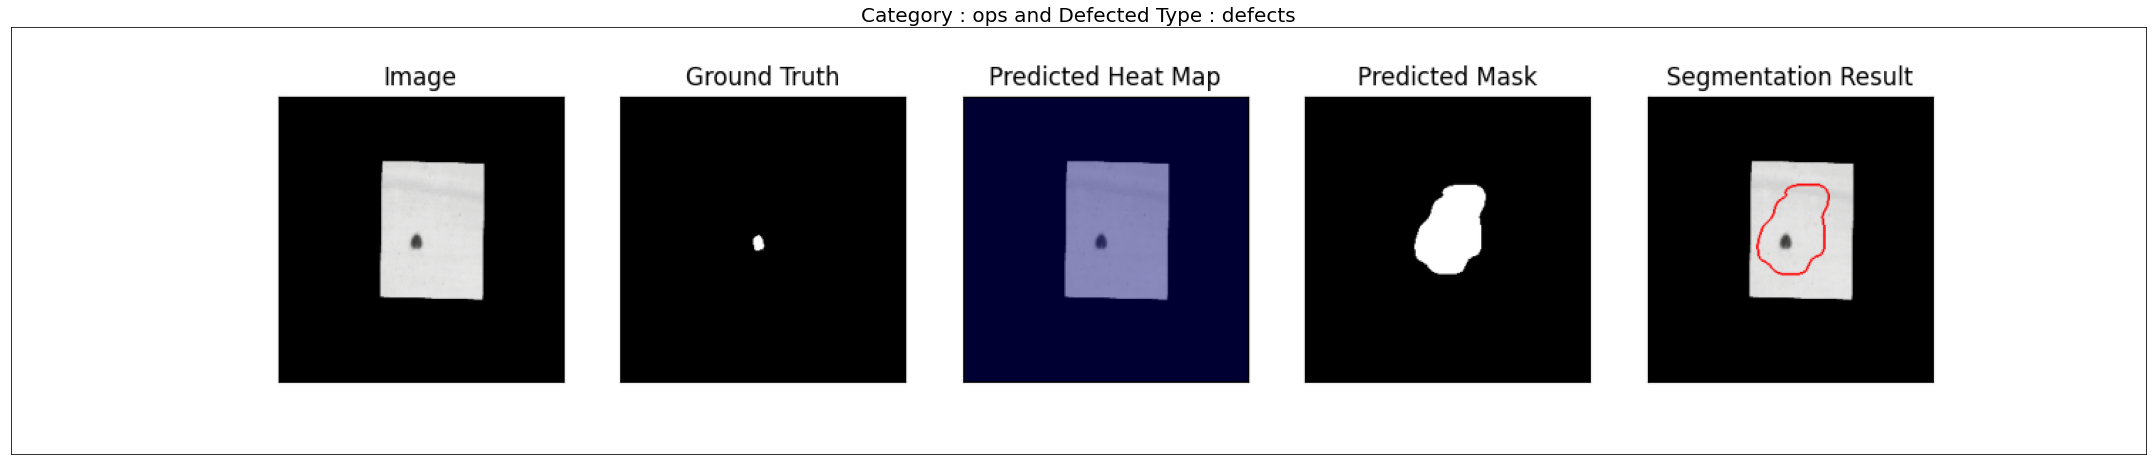

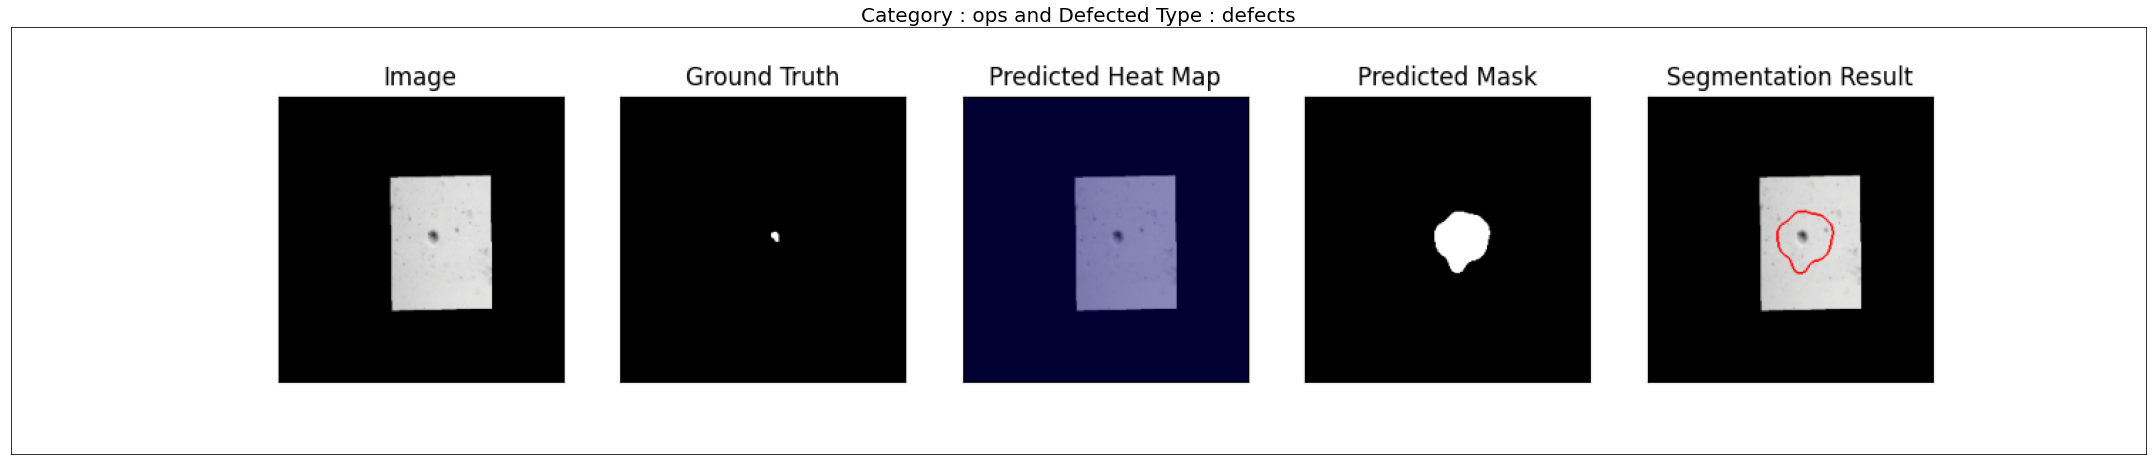

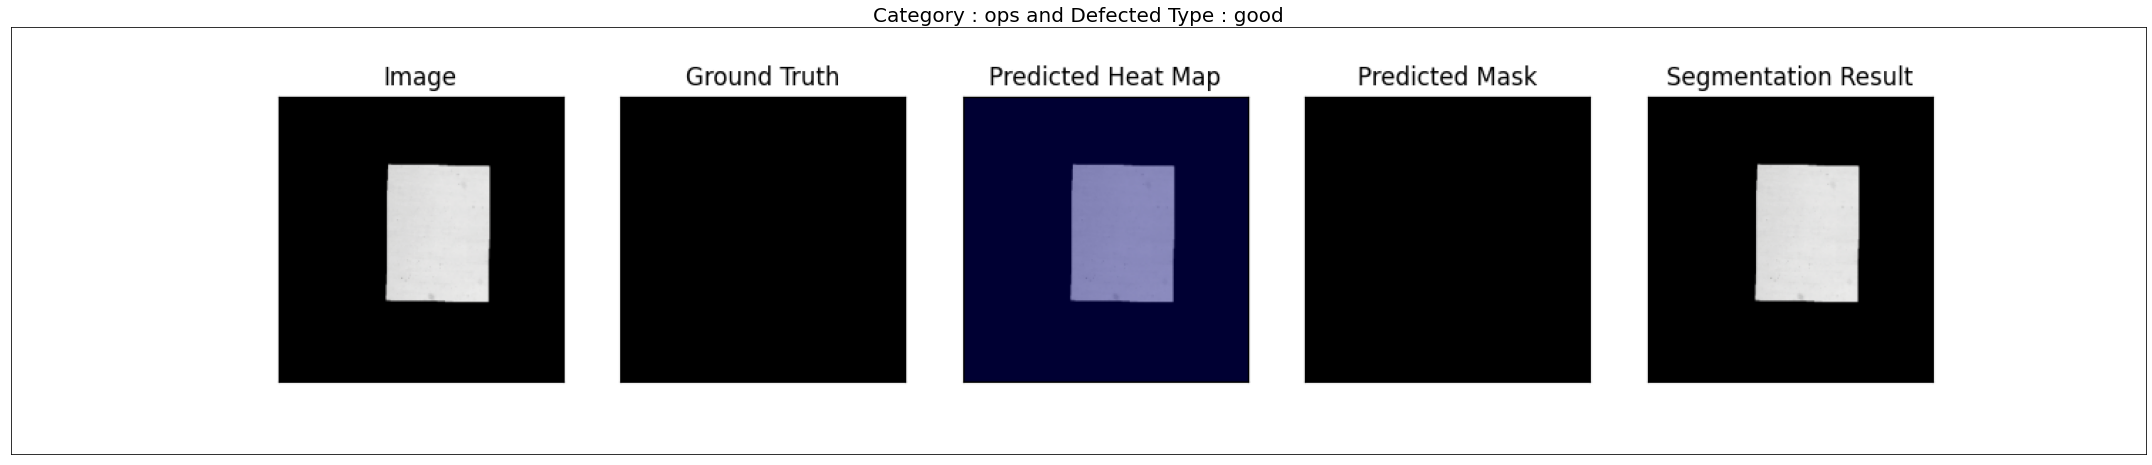

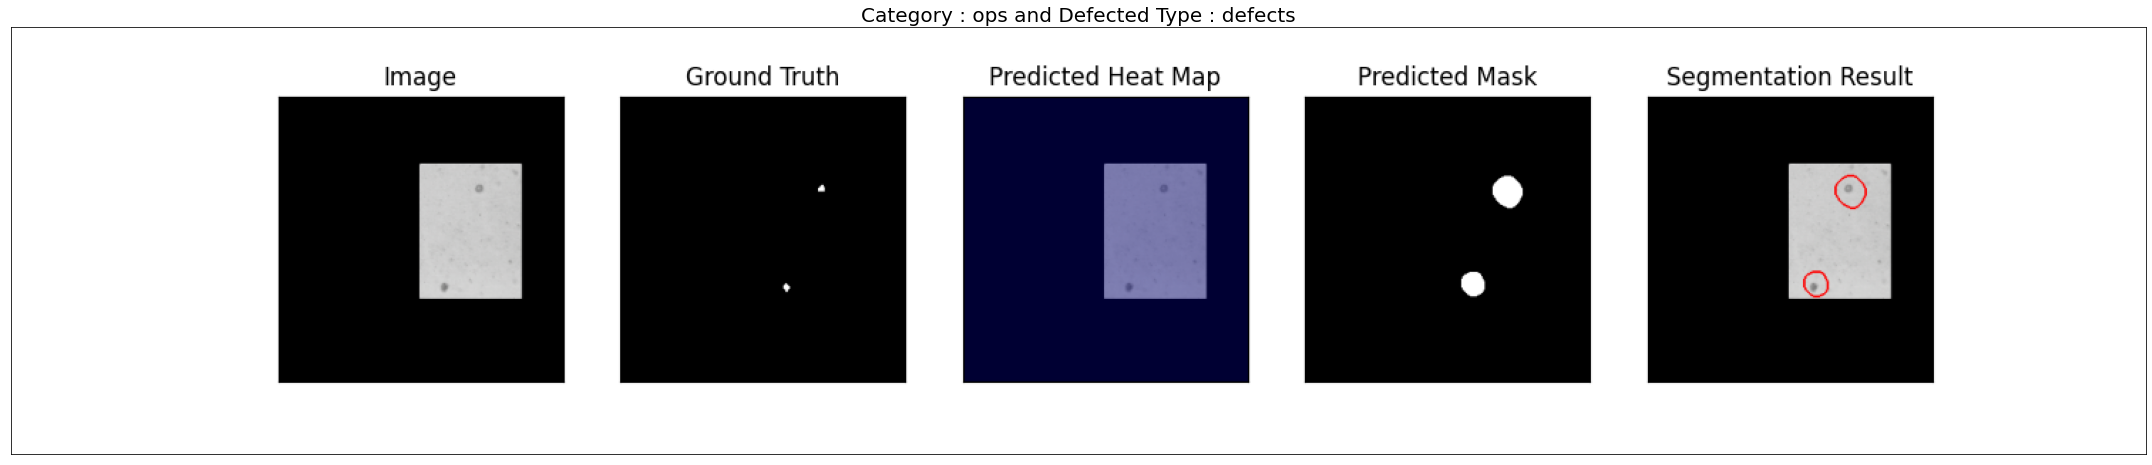

In [25]:
vis(full_path, 10, is_random=True, figsize=(30, 30))